# Comparison to CCL

This notebook compares the implementation from jax_cosmo to CCL

In [1]:
%pylab inline
import os
os.environ['JAX_ENABLE_X64']='True'

import pyccl as ccl
import jax
from jax_cosmo import Cosmology, background

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax_cosmo
jax_cosmo.__version__

'0.1rc9'

In [3]:
ccl.__version__

'2.5.1'

In [4]:
# We first define equivalent CCL and jax_cosmo cosmologies
#cosmo_ccl = ccl.Cosmology(
#    Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0,
#   transfer_function='eisenstein_hu', matter_power_spectrum='halofit')

cosmo_ccl = ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')
#cosmo_ccl.cosmo.gsl_params.INTEGRATION_EPSREL = 1e-10

cosmo_jax = Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96,
                      Omega_k=0., w0=-1., wa=0.)

## Comparing background cosmology

In [5]:
# Test array of scale factors
z_max = 10.
a_min = 1./(1.+z_max)
a = np.linspace(a_min, 1.)

/tmp/ipykernel_23230/4211138849.py:16: RuntimeWarning: invalid value encountered in true_divide
  difference=np.abs(chi_ccl-chi_jax)/chi_ccl   * 1e2


Text(0.5, 0, 'a')

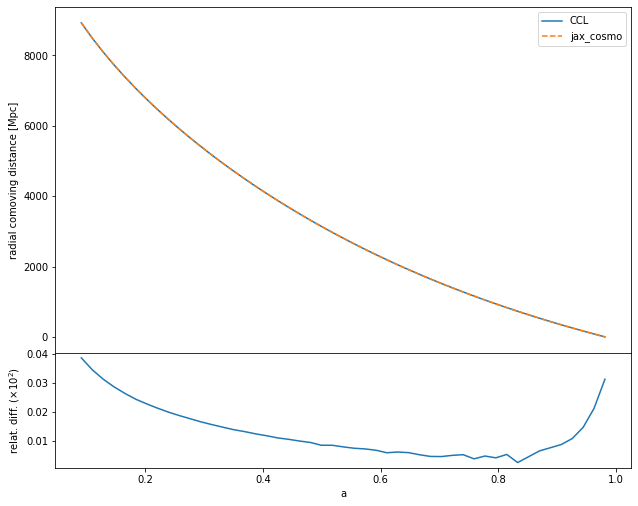

In [6]:
# Testing the radial comoving distance
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

chi_ccl = ccl.comoving_radial_distance(cosmo_ccl, a)
chi_jax = background.radial_comoving_distance(cosmo_jax, a, steps=1024)/cosmo_jax.h

plot(a, chi_ccl, label='CCL')
plot(a, chi_jax, '--', label='jax_cosmo')
legend()
ylabel('radial comoving distance [Mpc]')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(chi_ccl-chi_jax)/chi_ccl   * 1e2
plot(a,difference)
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('a')

/tmp/ipykernel_23230/3472650285.py:14: RuntimeWarning: invalid value encountered in true_divide
  difference=np.abs(chi_ccl-chi_jax)/chi_ccl   * 1e2


Text(0.5, 0, 'a')

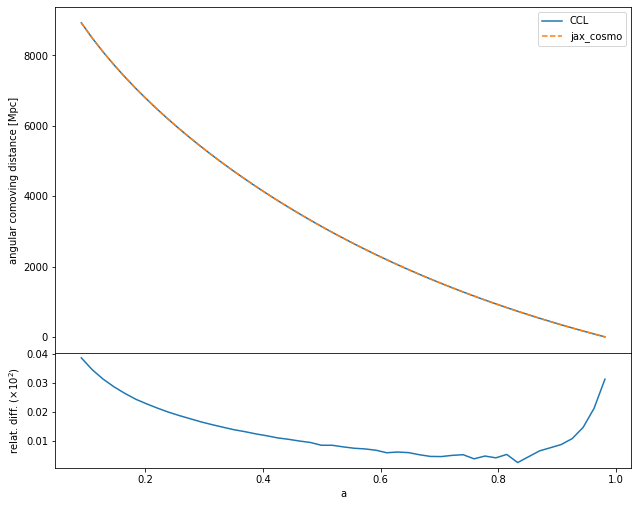

In [7]:
# Testing the angular comoving distance
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
chi_ccl = ccl.comoving_angular_distance(cosmo_ccl, a)
chi_jax = background.transverse_comoving_distance(cosmo_jax, a)/cosmo_jax.h

plot(a, chi_ccl, label='CCL')
plot(a, chi_jax, '--', label='jax_cosmo')
legend()
ylabel('angular comoving distance [Mpc]')

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(chi_ccl-chi_jax)/chi_ccl   * 1e2
plot(a,difference)
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('a')

/tmp/ipykernel_23230/3672972325.py:16: RuntimeWarning: invalid value encountered in true_divide
  difference=np.abs(chi_ccl-chi_jax)/chi_ccl   * 1e2


Text(0.5, 0, 'a')

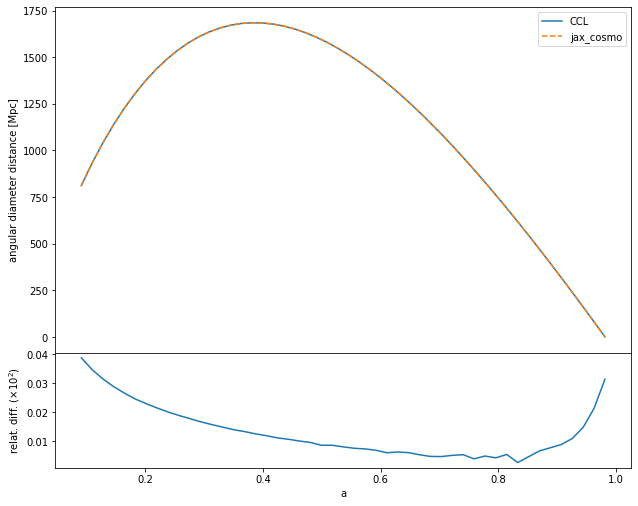

In [8]:
# Testing the angular diameter distance
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
chi_ccl = ccl.angular_diameter_distance(cosmo_ccl, a)
chi_jax = background.angular_diameter_distance(cosmo_jax, a)/cosmo_jax.h

plot(a, chi_ccl, label='CCL')
plot(a, chi_jax, '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('angular diameter distance [Mpc]')


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(chi_ccl-chi_jax)/chi_ccl   * 1e2
plot(a,difference)
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('a')


Text(0.5, 0, 'a')

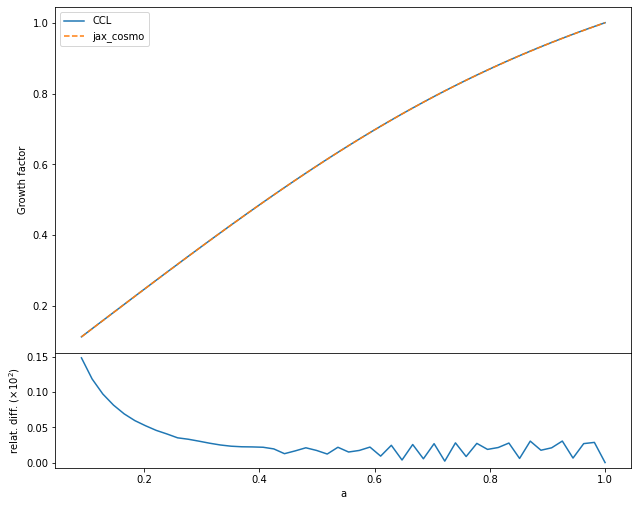

In [9]:
# Comparing the growth factor
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
ccl_growth = ccl.growth_factor(cosmo_ccl,a)
jax_growth = background.growth_factor(cosmo_jax, a)

plot(a, ccl_growth, label='CCL')
plot(a, jax_growth, '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('Growth factor')

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(ccl_growth-jax_growth)/ccl_growth   * 1e2
plot(a,difference)
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('a')


Text(0.5, 0, 'a')

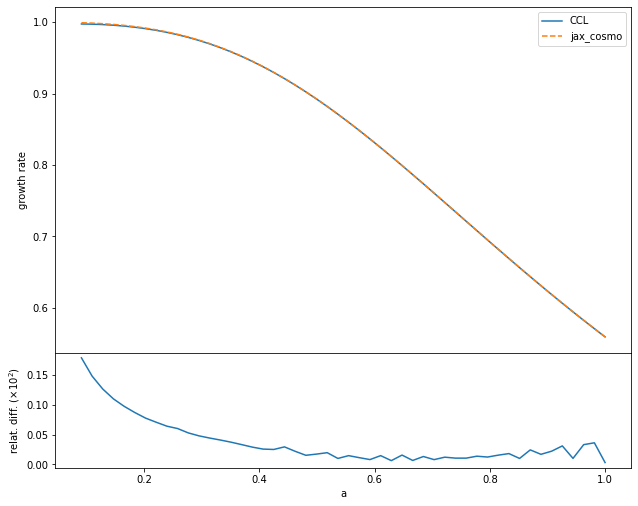

In [10]:
# Comparing linear growth rate
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

ccl_growth_rate = ccl.growth_rate(cosmo_ccl,a)
jax_growth_rate = background.growth_rate(cosmo_jax, a)

plot(a, ccl_growth_rate, label='CCL')
plot(a, jax_growth_rate, '--', label='jax_cosmo')
legend()
xlabel('a')
ylabel('growth rate')

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(ccl_growth_rate-jax_growth_rate)/ccl_growth_rate   * 1e2
plot(a,difference)
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('a')


## Comparing matter power spectrum

In [11]:
from jax_cosmo.power import linear_matter_power, nonlinear_matter_power

In [12]:
k = np.logspace(-3,-0.5)

Text(0.5, 0, 'k [Mpc]')

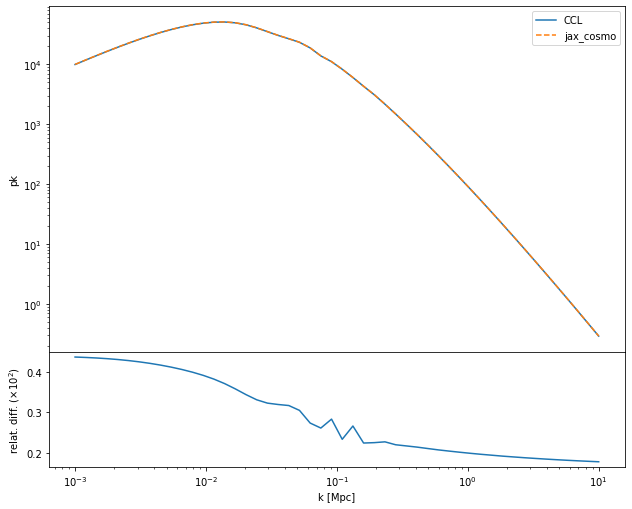

In [34]:
#Let's have a look at the linear power
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

#pk_ccl = ccl.linear_matter_power(cosmo_ccl, k, 1.0)
#pk_jax = linear_matter_power(cosmo_jax, k/cosmo_jax.h, a=1.0)

pk_ccl = ccl.linear_matter_power(cosmo_ccl, k, 1.0)
pk_jax = linear_matter_power(cosmo_jax, k/cosmo_jax.h, a=1.0)/cosmo_jax.h**3


loglog(k,pk_ccl,label='CCL')
loglog(k,pk_jax, '--', label='jax_cosmo')
legend()
xlabel('k [Mpc]')
ylabel('pk');

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(pk_ccl-pk_jax)/pk_ccl   * 1e2
plot(k,difference)
xscale("log")
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('k [Mpc]')


Text(0.5, 0, 'k [Mpc]')

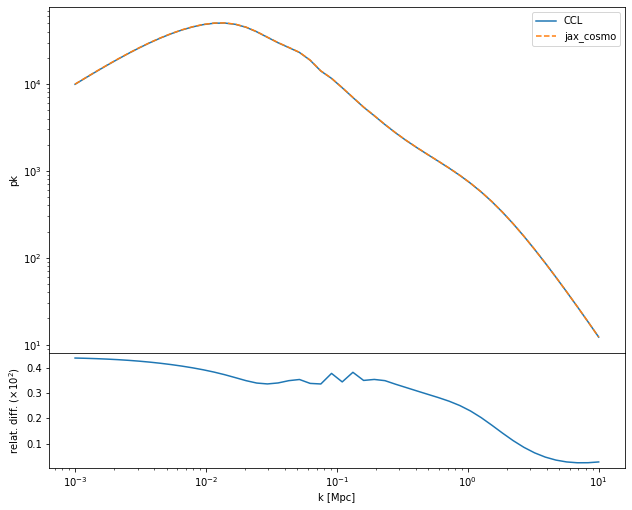

In [35]:
k = np.logspace(-3,1)
#Let's have a look at the non linear power
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

pk_ccl = ccl.nonlin_matter_power(cosmo_ccl, k, 1.0)
pk_jax = nonlinear_matter_power(cosmo_jax, k/cosmo_jax.h, a=1.0)/cosmo_jax.h**3

loglog(k,pk_ccl,label='CCL')
loglog(k,pk_jax, '--', label='jax_cosmo')
legend()
xlabel('k [Mpc]')
ylabel('pk');

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(pk_ccl-pk_jax)/pk_ccl   * 1e2
plot(k,difference)
xscale("log")
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel('k [Mpc]')



## Comparing angular cl

In [15]:
from jax_cosmo.redshift import smail_nz

# Let's define a redshift distribution
# with a Smail distribution with a=1, b=2, z0=1
nz = smail_nz(1.,2., 1.)

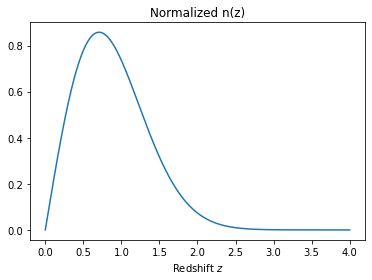

In [16]:
z = linspace(0,4,1024)
plot(z, nz(z))
xlabel(r'Redshift $z$');
title('Normalized n(z)');

In [17]:
from jax_cosmo.angular_cl import angular_cl
from jax_cosmo import probes

# Let's first compute some Weak Lensing cls
tracer_ccl = ccl.WeakLensingTracer(cosmo_ccl, (z, nz(z)), use_A_ia=False)
tracer_jax = probes.WeakLensing([nz])

ell = np.logspace(0.1,3)

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax])

Text(0.5, 0, '$\\ell$')

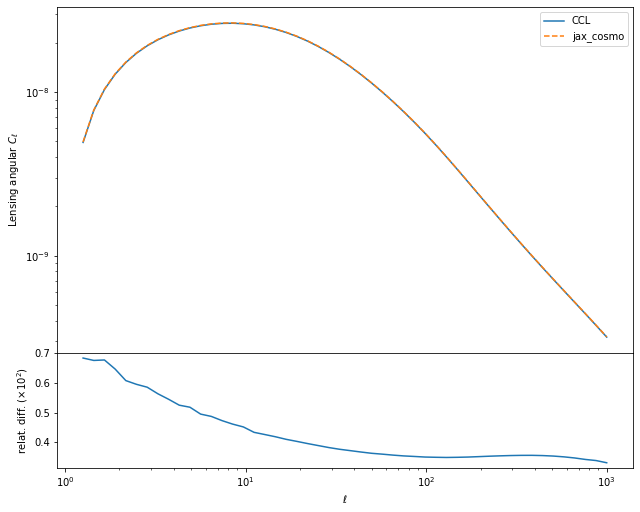

In [18]:
fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
loglog(ell, cl_ccl,label='CCL')
loglog(ell, cl_jax[0], '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'Lensing angular $C_\ell$')


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(cl_ccl-cl_jax[0])/cl_ccl   * 1e2
plot(ell,difference)
xscale("log")
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel(r'$\ell$')


In [19]:
# Let's try galaxy clustering now
from jax_cosmo.bias import constant_linear_bias

# We define a trivial bias model
bias = constant_linear_bias(1.)

tracer_ccl_n = ccl.NumberCountsTracer(cosmo_ccl,
                                      has_rsd=False,
                                      dndz=(z, nz(z)),
                                      bias=(z, bias(cosmo_jax, z)))
tracer_jax_n = probes.NumberCounts([nz], bias)

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl_n, tracer_ccl_n, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax_n])

Text(0.5, 0, '$\\ell$')

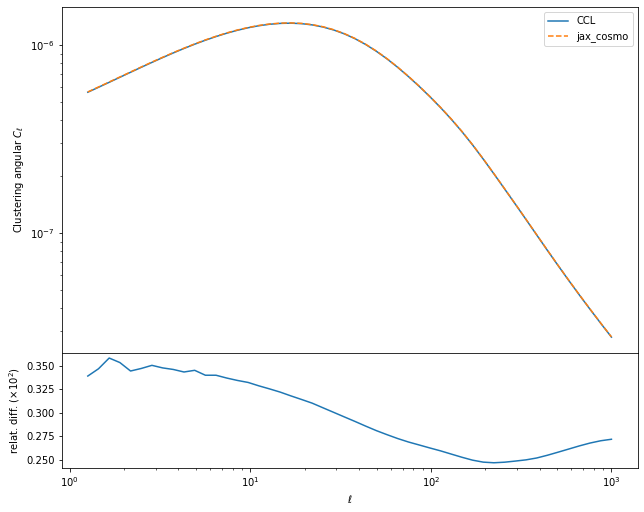

In [20]:
import jax_cosmo.constants as cst

fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

loglog(ell, cl_ccl,label='CCL')
loglog(ell, cl_jax[0], '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'Clustering angular $C_\ell$')

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(cl_ccl-cl_jax[0])/cl_ccl   * 1e2
plot(ell,difference)
xscale("log")
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel(r'$\ell$')


In [21]:
# And  finally.... a cross-spectrum

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl_n, ell)
cl_jax = angular_cl(cosmo_jax, ell, [tracer_jax, tracer_jax_n])

Text(0.5, 0, '$\\ell$')

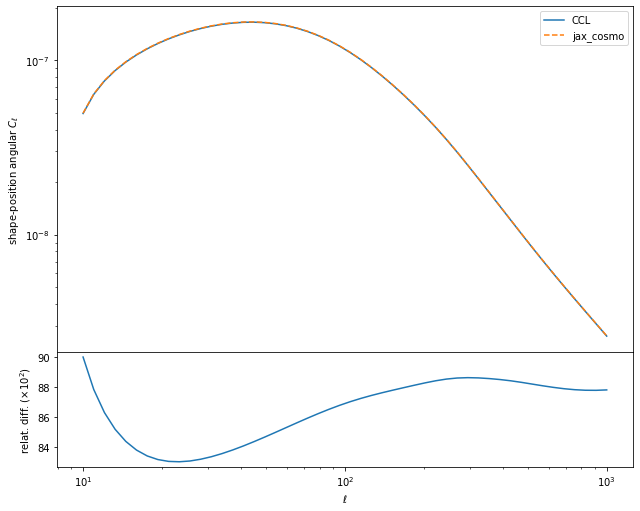

In [22]:
ell = np.logspace(1,3)

fig1 = plt.figure(1, figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))

loglog(ell, cl_ccl,label='CCL')
loglog(ell, cl_jax[1], '--', label='jax_cosmo')

legend()
xlabel(r'$\ell$')
ylabel(r'shape-position angular $C_\ell$')

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))
difference=np.abs(cl_ccl-cl_jax[0])/cl_ccl   * 1e2
plot(ell,difference)
xscale("log")
ylabel(r"relat. diff. $(\times 10^{2})$");
xlabel(r'$\ell$')


In [23]:
cl_ccl[:10], cl_jax[0][:10]

(array([4.95334392e-08, 6.38283711e-08, 7.62064169e-08, 8.74147304e-08,
        9.77799505e-08, 1.07461006e-07, 1.16531389e-07, 1.25012526e-07,
        1.32889855e-07, 1.40121168e-07]),
 DeviceArray([4.95893452e-09, 7.76835119e-09, 1.04418384e-08,
              1.29486402e-08, 1.52707944e-08, 1.73999277e-08,
              1.93231414e-08, 2.10297320e-08, 2.25165327e-08,
              2.37768420e-08], dtype=float64))